We need sktime and statsforecast libraries for the forecast, pmdarima is needed for ARIMA model parameter search. We'll load the same dataset, the airline passengers time series, with sktime and with statsforecast convenience functions.

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

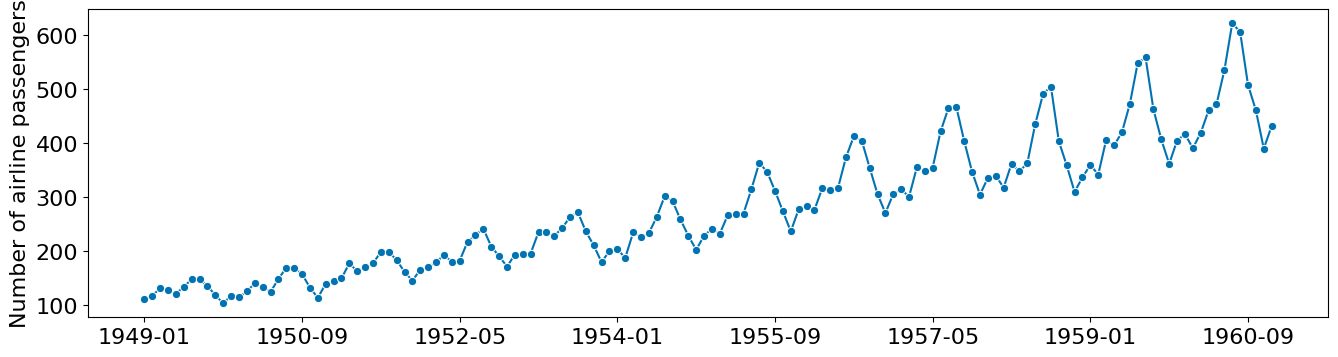

In [49]:
from sktime.datasets import load_airline
from sktime.utils.plotting import plot_series

y = load_airline()

# plotting for visualization
plot_series(y)

In [50]:
y

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [53]:
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y)

In [56]:
from sktime.forecasting.base import ForecastingHorizon
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("1961-01", periods=36, freq="M")), is_relative=False
)
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

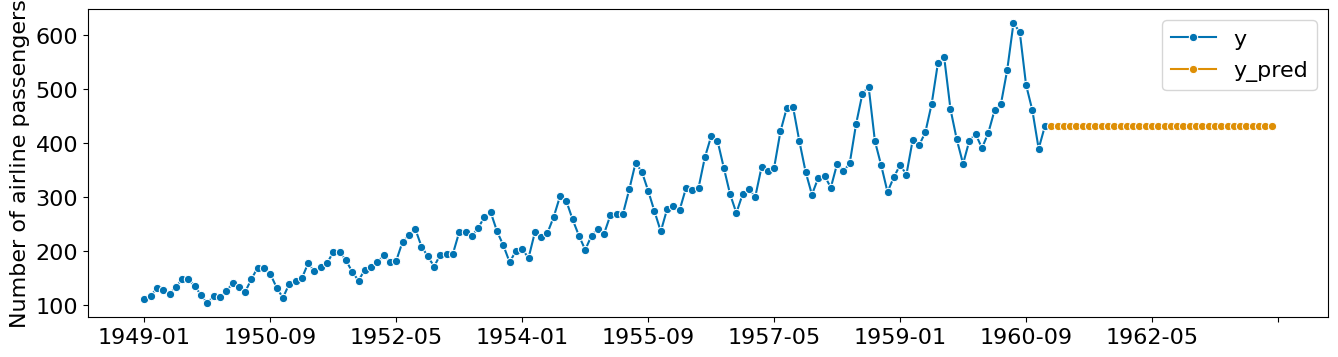

In [57]:
plot_series(y, y_pred, labels=["y", "y_pred"])

In [65]:
from sktime.forecasting.arima import ARIMA

forecaster = ARIMA()
forecaster.fit(y)
y_pred = forecaster.predict(fh)

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

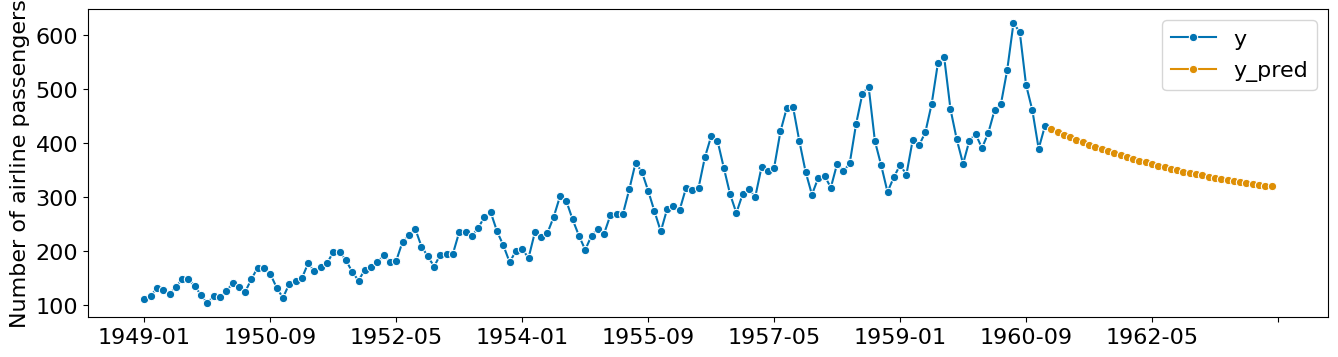

In [66]:
plot_series(y, y_pred, labels=["y", "y_pred"])

In [68]:
from statsforecast.models import AutoARIMA

forecaster = AutoARIMA()
forecaster.fit(y)
y_pred = forecaster.predict(fh)

/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/b

(<Figure size 1600x400 with 1 Axes>,
 <AxesSubplot: ylabel='Number of airline passengers'>)

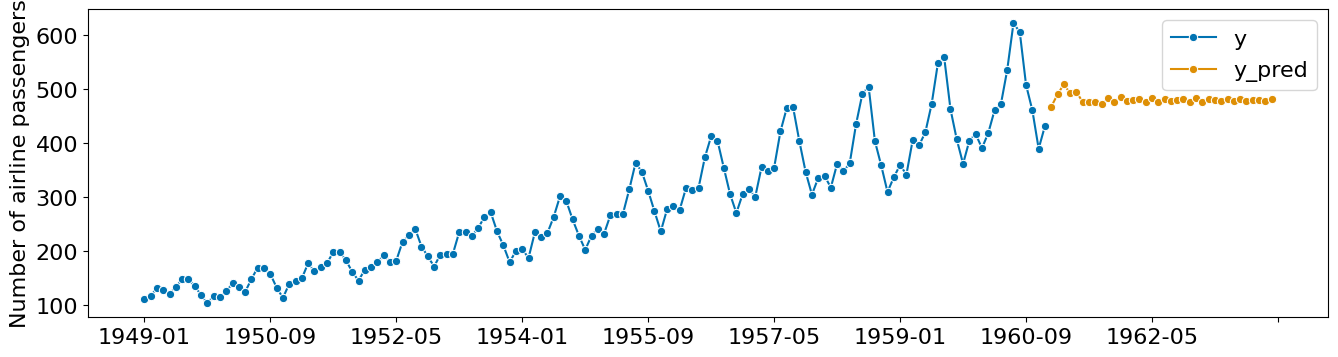

In [69]:
plot_series(y, y_pred, labels=["y", "y_pred"])

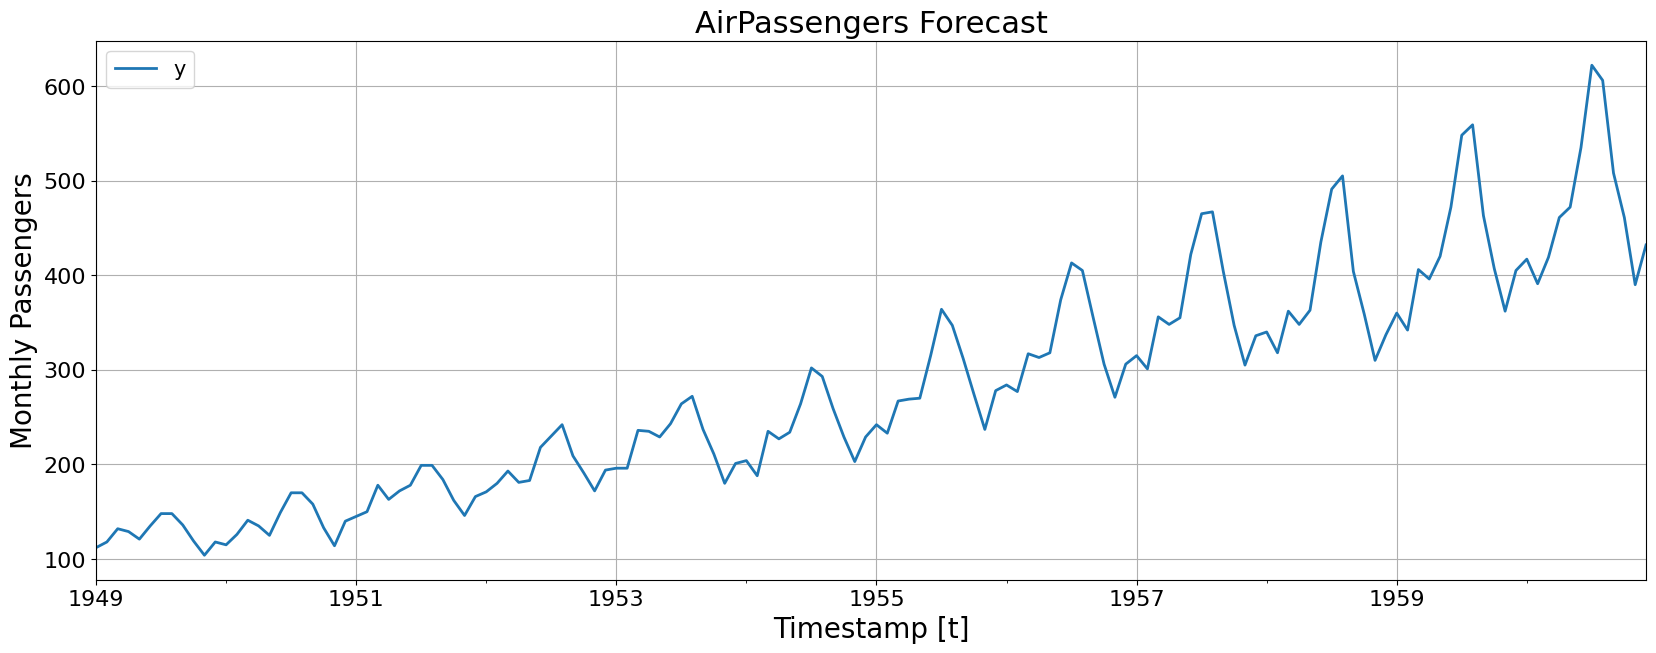

In [74]:
from statsforecast.utils import AirPassengersDF

fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = AirPassengersDF.set_index('ds')

plot_df[['y']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [75]:
plot_df

,unique_id,y
ds,,
1949-01-31,1.0,112.0
1949-02-28,1.0,118.0
1949-03-31,1.0,132.0
1949-04-30,1.0,129.0
1949-05-31,1.0,121.0
...,...,...
1960-08-31,1.0,606.0
1960-09-30,1.0,508.0
1960-10-31,1.0,461.0


In [78]:
Y_train_df = AirPassengersDF[AirPassengersDF.ds<='1959-12-31'] # 132 monthly observations for train
Y_test_df = AirPassengersDF[AirPassengersDF.ds>'1959-12-31'] # 12 monthly observations for test

In [81]:
from statsforecast.models import Naive
from statsforecast import StatsForecast


models = [
    Naive()
]
sf = StatsForecast(
    df=Y_train_df,
    models=models,
    freq='M', 
    n_jobs=-1
)
Y_hat_df = sf.forecast(horizon)

,ds,Naive
unique_id,,
1.0,1960-01-31,405.0
1.0,1960-02-29,405.0
1.0,1960-03-31,405.0
1.0,1960-04-30,405.0
1.0,1960-05-31,405.0


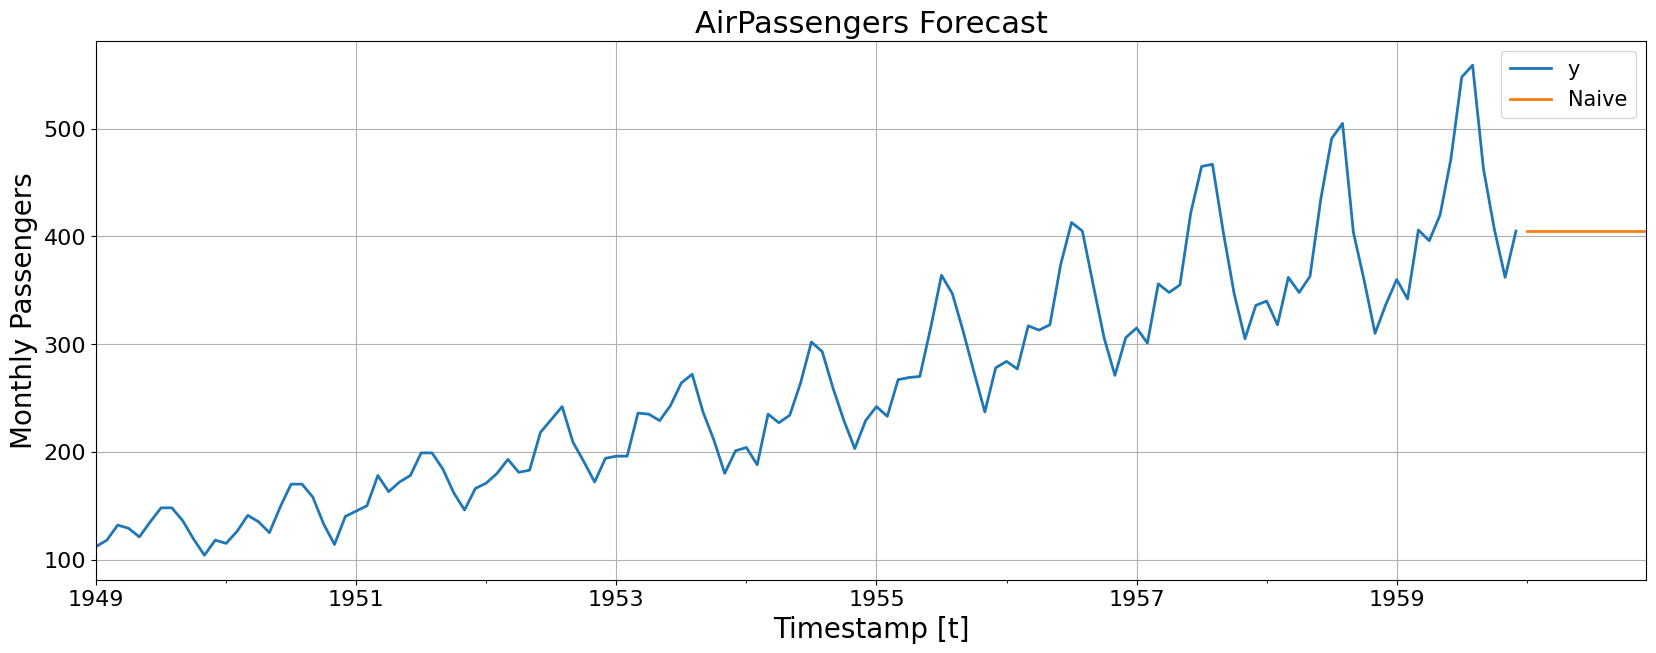

In [90]:
import matplotlib.pyplot as plt
Y_hat_df = Y_test_df.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])


fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')
plot_df[['y', 'Naive']].plot(ax=ax, linewidth=2)
ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [87]:
import numpy as np

def mae(y_hat, y_true):
    return np.mean(np.abs(y_hat-y_true))

y_true = Y_test_df['y'].values
naive_preds = Y_hat_df['Naive'].values

print('Naive MAE: %0.3f' % mae(naive_preds, y_true))

Naive MAE: 76.000


In [138]:
from statsforecast.models import AutoARIMA, ETS, Theta, AutoCES

season_length = 12 # Monthly data 
horizon = len(Y_test_df) # Predict the lenght of the test df

models = [
    ETS(season_length=season_length),
    Naive(),
    Theta(season_length=season_length),
    AutoARIMA(season_length=season_length),
    AutoCES(season_length=season_length)
]

# Instansiate the StatsForecast class as sf
sf = StatsForecast(
    df=Y_train_df,
    models=models,
    freq='M', 
    n_jobs=-1
)

# Forecast for the defined horizon
Y_hat_df = sf.forecast(horizon)

Y_hat_df.head()

/opt/anaconda3/envs/book/lib/python3.10/site-packages/statsforecast/models.py:526: FutureWarning: `ETS` will be deprecated in future versions of `StatsForecast`. Please use `AutoETS` instead.
  ETS._warn()


,ds,ETS,Naive,Theta,AutoARIMA,CES
unique_id,,,,,,
1.0,1960-01-31,406.651276,405.0,411.370270,424.160156,410.827393
1.0,1960-02-29,401.732910,405.0,402.274689,407.081696,391.996124
1.0,1960-03-31,456.289642,405.0,462.882843,470.860535,456.414459
1.0,1960-04-30,440.870514,405.0,444.674957,460.913605,447.666779
1.0,1960-05-31,440.333923,405.0,447.932404,484.900879,472.150970


In [183]:
def calculate_errors(Y_test_df, Y_hat_df):
    errors = {}
    for col in Y_hat_df.columns:
        if col in ["y", "ds"]:
            continue
        error = mae(Y_hat_df[col].values, Y_test_df.y.values)
        errors[col] = error
        aggregate_results = pd.DataFrame([errors])
    return aggregate_results

calculate_errors(Y_test_df, Y_hat_df)

,ETS,Naive,Theta,AutoARIMA,CES
0,35.612475,76.0,26.30115,18.550588,10.145073


In [140]:
Y_test_df

,unique_id,ds,y
132,1.0,1960-01-31,417.0
133,1.0,1960-02-29,391.0
134,1.0,1960-03-31,419.0
135,1.0,1960-04-30,461.0
136,1.0,1960-05-31,472.0
137,1.0,1960-06-30,535.0
138,1.0,1960-07-31,622.0
139,1.0,1960-08-31,606.0
140,1.0,1960-09-30,508.0
141,1.0,1960-10-31,461.0


In [175]:
def plot_forecasts(y_train, y_true, y_pred, models: list[str]):
    _, ax = plt.subplots(1, 1, figsize = (20, 7))
    if 'ds' in y_pred.columns:
        y_true = y_true.merge(y_pred, how='left', on=['unique_id', 'ds'])
    else:
        y_true = y_true.join(y_pred, how='left')
    df_plot = pd.concat([y_train, y_true]).set_index('ds').tail(24 * 7)
    df_plot[['y'] + models].plot(ax=ax, linewidth=2, style=['r*-','bo--','y^--', 'gx-', 'm.-'])
    ax.set_xlabel('Timestamp [t]', fontsize=20)
    ax.legend(prop={'size': 15})
    ax.grid()


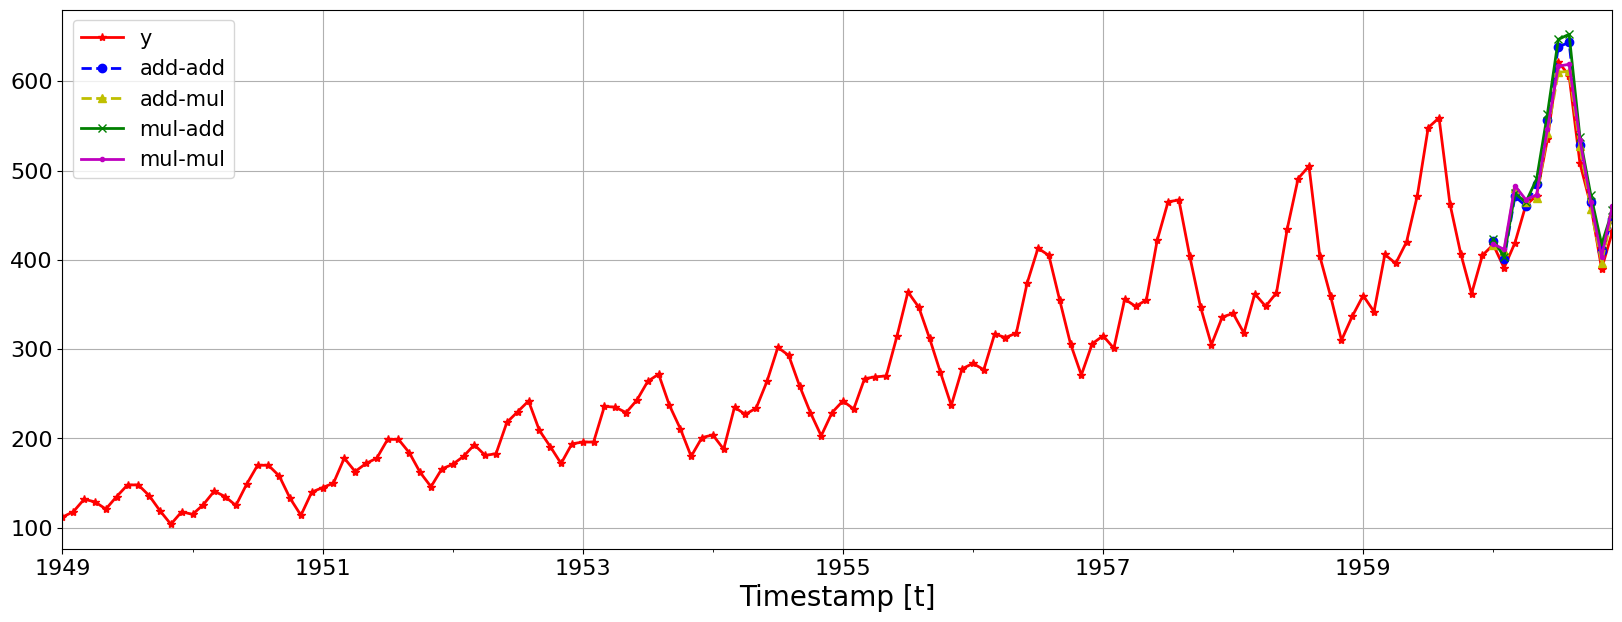

In [178]:
from statsmodels.tsa.api import ExponentialSmoothing

exp_smoothing_results = {}
for trend in ["add", "mul"]:
    for seasonal in ["add", "mul"]:
mod = ExponentialSmoothing(
    Y_train_df[["y"]],
    seasonal_periods=season_length,
    trend=trend,
    seasonal=seasonal,
    use_boxcox=True,
    initialization_method="estimated",
).fit()
exp_smoothing_results[f"{trend}-{seasonal}"] = mod.forecast(horizon)
    
exp_results_df = pd.DataFrame(data=exp_smoothing_results)
plot_forecasts(
    Y_train_df, Y_test_df, exp_results_df,
    models=list(exp_results_df.columns)
)
Y_hat_df["ETS"] = exp_results_df["add-mul"]

In [184]:
calculate_errors(Y_test_df, exp_results_df)

,add-add,add-mul,mul-add,mul-mul
0,17.836339,13.470884,23.917536,16.232367


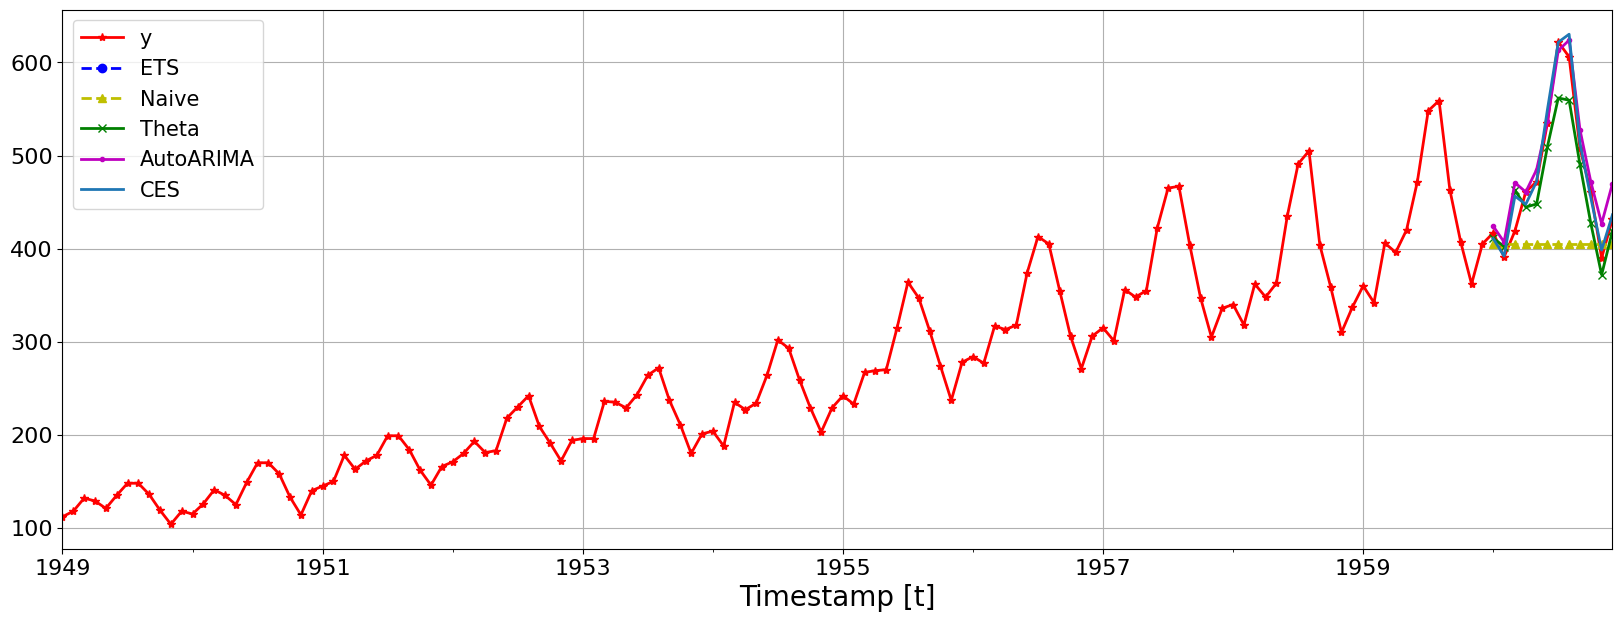

In [190]:
plot_forecasts(
    Y_train_df, Y_test_df, Y_hat_df,
    models=['ETS', 'Naive', 'Theta', 'AutoARIMA', 'CES']
)